In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/mnist/

/content/gdrive/MyDrive/mnist


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPool2D, Dropout, BatchNormalization
import cv2

In [4]:
def load_file(file_name):
    """Load a file in one of the formats provided in the OpenKBP dataset
    :param file_name: the name of the file to be loaded
    :return: the file loaded
    """
    # Load the file as a csv
    loaded_file_df = pd.read_csv(file_name, index_col=0)
    # If the csv is voxel dimensions read it with numpy
    if 'voxel_dimensions.csv' in file_name:
        loaded_file = np.loadtxt(file_name)
    # Check if the data has any values
    elif loaded_file_df.isnull().values.any():
        # Then the data is a vector, which we assume is for a mask of ones
        loaded_file = np.array(loaded_file_df.index).squeeze()
    else:
        # Then the data is a matrix of indices and data points
        loaded_file = {'indices': np.array(loaded_file_df.index).squeeze(),
                       'data': np.array(loaded_file_df['data']).squeeze()}

    return loaded_file


def get_paths(directory_path, ext=''):
    """Get the paths of every file with a specified extension in a directory
    :param directory_path: the path of the directory of interest
    :param ext: the extensions of the files of interest
    :return: the path of all files of interest
    """
    # if dir_name doesn't exist return an empty array
    if not os.path.isdir(directory_path):
        return []
    # Otherwise dir_name exists and function returns contents name(s)
    else:
        all_image_paths = []
        # If no extension given, then get all files
        if ext == '':
            dir_list = os.listdir(directory_path)
            for iPath in dir_list:
                if '.' != iPath[0]:  # Ignore hidden files
                    all_image_paths.append('{}/{}'.format(directory_path, str(iPath)))
        else:
            # Get list of paths for files with the extension ext
            data_root = pathlib.Path(directory_path)
            for iPath in data_root.glob('*.{}'.format(ext)):
                all_image_paths.append(str(iPath))

    return all_image_paths


def get_paths_from_sub_directories(main_directory_path, sub_dir_list, ext=''):
    """Compiles a list of all paths within each sub directory listed in sub_dir_list that follows the main_dir_path
    :param main_directory_path: the path for the main directory of interest
    :param sub_dir_list: the name(s) of the directory of interest that are in the main_directory
    :param ext: the extension of the files of interest (in the usb directories)
    :return:
    """
    # Initialize list of paths
    path_list = []
    # Iterate through the sub directory names and build up the path list
    for sub_dir in sub_dir_list:
        paths_to_add = get_paths('{}/{}'.format(main_directory_path, sub_dir), ext=ext)
        path_list.extend(paths_to_add)

    return path_list


def sparse_vector_function(x, indices=None):
    """Convert a tensor into a dictionary of the non zero values and their corresponding indices
    :param x: the tensor or, if indices is not None, the values that belong at each index
    :param indices: the raveled indices of the tensor
    :return:  sparse vector in the form of a dictionary
    """
    if indices is None:
        y = {'data': x[x > 0], 'indices': np.nonzero(x.flatten())[-1]}
    else:
        y = {'data': x[x > 0], 'indices': indices[x > 0]}
    return y


def make_directory_and_return_path(dir_path):
    """Makes a directory only if it does not already exist
    :param dir_path: the path of the directory to be made
    :return: returns the directory path
    """
    os.makedirs(dir_path, exist_ok=True)

    return dir_path

In [5]:
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

In [6]:
y_train = train_data.iloc[:, 0]
X_train = train_data.iloc[:, 1:]

In [7]:
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]

In [8]:
images_train = np.zeros([60000, 28, 28])
for i in range(60000):
  temp = np.reshape(np.array(X_train.iloc[i, :]), (28, 28))
  temp = temp.astype('float64')
  # temp[:, 0] = np.full(28, 255, 'float64')
  # temp[:, 27] = np.full(28, 255, 'float64')
  # temp[0, :] = np.full(28, 255, 'float64')
  # temp[27, :] = np.full(28, 255, 'float64')
  images_train[i] = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)[1]

images_test = np.zeros([10000, 28, 28])
for i in range(10000):
  temp = np.reshape(np.array(X_test.iloc[i, :]), (28, 28))
  temp = temp.astype('float64')
  # temp[:, 0] = np.full(28, 255, 'float64')
  # temp[:, 27] = np.full(28, 255, 'float64')
  # temp[0, :] = np.full(28, 255, 'float64')
  # temp[27, :] = np.full(28, 255, 'float64')
  images_test[i] = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)[1]

In [12]:
np.unique(images_train)

array([  0., 255.])

In [13]:
images_train.shape

(60000, 28, 28)

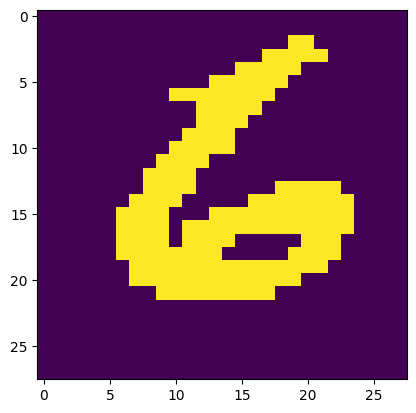

In [14]:
plt.imshow(images_test[i])

In [ ]:
bw_images_train = np.array(cv2.threshold(images_train, 127, 255, cv2.THRESH_BINARY))
bw_images_test = np.array(cv2.threshold(images_test, 127, 255, cv2.THRESH_BINARY))

# Model nhẹ

In [41]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(28, 28, 1)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics="accuracy")
model.fit(np.expand_dims(images_train, -1), y_train.to_numpy(), epochs=100, batch_size=32, validation_split=0.1)

# Model nặng

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model.fit(bw_images_train[1], y_train, epochs=10)

In [ ]:
test_loss, test_acc = model.evaluate(np.expand_dims(images_test, axis=-1), y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.9940


In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size = 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(64, kernel_size = 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size = 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(128, kernel_size = 4, activation='relu'))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model2.fit(bw_images_train[1], y_train, epochs=20)

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size = 3, activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Conv2D(64, kernel_size = 3, activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size = 3, activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.4))

model3.add(Conv2D(128, kernel_size = 4, activation='relu'))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dropout(0.4))
model3.add(Dense(10, activation='softmax'))

model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model3.fit(bw_images_train[1], y_train, epochs=50)

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model4.add(BatchNormalization())
model4.add(Conv2D(32, kernel_size = 3, activation='relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

model4.add(Conv2D(64, kernel_size = 3, activation='relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size = 3, activation='relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.4))

model4.add(Conv2D(128, kernel_size = 4, activation='relu'))
model4.add(BatchNormalization())
model4.add(Flatten())
model4.add(Dropout(0.4))
model4.add(Dense(10, activation='softmax'))

model4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model4.fit(bw_images_train[1], y_train, epochs=100)

In [ ]:
model5 = Sequential()
model5.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model5.add(BatchNormalization())
model5.add(Conv2D(32, kernel_size = 3, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))

model5.add(Conv2D(64, kernel_size = 3, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, kernel_size = 3, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.4))

model5.add(Conv2D(128, kernel_size = 4, activation='relu'))
model5.add(BatchNormalization())
model5.add(Flatten())
model5.add(Dropout(0.4))
model5.add(Dense(10, activation='softmax'))

model5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model5.fit(bw_images_train[1], y_train, epochs=5)

In [ ]:
model6 = Sequential()
model6.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model6.add(BatchNormalization())
model6.add(Conv2D(32, kernel_size = 3, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.4))

model6.add(Conv2D(64, kernel_size = 3, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(64, kernel_size = 3, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.4))

model6.add(Conv2D(128, kernel_size = 4, activation='relu'))
model6.add(BatchNormalization())
model6.add(Flatten())
model6.add(Dropout(0.4))
model6.add(Dense(10, activation='softmax'))

model6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model6.fit(bw_images_train[1][0:19999], y_train[0:19999], epochs=20)

Epoch 1/20
625/625 [==============================] - 5s 7ms/step - loss: 0.3878 - accuracy: 0.8848
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 0.1095 - accuracy: 0.9654
Epoch 3/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0838 - accuracy: 0.9735
Epoch 4/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0686 - accuracy: 0.9785
Epoch 5/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0639 - accuracy: 0.9817
Epoch 6/20
625/625 [==============================] - 5s 9ms/step - loss: 0.0589 - accuracy: 0.9819
Epoch 7/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0517 - accuracy: 0.9843
Epoch 8/20
625/625 [==============================] - 5s 8ms/step - loss: 0.0489 - accuracy: 0.9836
Epoch 9/20
625/625 [==============================] - 6s 9ms/step - loss: 0.0435 - accuracy: 0.9861
Epoch 10/20
625/625 [==============================] - 5s 9ms/step - loss: 0.0425 - accuracy: 0.9872

In [ ]:
model7 = Sequential()
model7.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model7.add(BatchNormalization())
model7.add(Conv2D(32, kernel_size = 3, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.4))

model7.add(Conv2D(64, kernel_size = 3, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(64, kernel_size = 3, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.4))

model7.add(Conv2D(128, kernel_size = 4, activation='relu'))
model7.add(BatchNormalization())
model7.add(Flatten())
model7.add(Dropout(0.4))
model7.add(Dense(10, activation='softmax'))

model7.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model7.fit(bw_images_train[1][0:49999], y_train[0:49999], epochs=20)

Epoch 1/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2163 - accuracy: 0.9340
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0810 - accuracy: 0.9759
Epoch 3/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0686 - accuracy: 0.9791
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0582 - accuracy: 0.9825
Epoch 5/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0509 - accuracy: 0.9846
Epoch 6/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0472 - accuracy: 0.9858
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0412 - accuracy: 0.9877
Epoch 8/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0345 - accuracy: 0.9896
Epoch 9/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0325 - accuracy: 0.9899
Epoch 10/20
1563/1563 [==============================] - 9s 6ms/step - loss: 

In [ ]:
model8 = Sequential()
model8.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model8.add(BatchNormalization())
model8.add(Conv2D(32, kernel_size = 3, activation='relu'))
model8.add(BatchNormalization())
model8.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.4))

model8.add(Conv2D(64, kernel_size = 3, activation='relu'))
model8.add(BatchNormalization())
model8.add(Conv2D(64, kernel_size = 3, activation='relu'))
model8.add(BatchNormalization())
model8.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.4))

model8.add(Conv2D(128, kernel_size = 4, activation='relu'))
model8.add(BatchNormalization())
model8.add(Flatten())
model8.add(Dropout(0.4))
model8.add(Dense(10, activation='softmax'))

model8.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")
model8.fit(bw_images_train[1][20000:], y_train[20000:], epochs=20)

Epoch 1/20
1250/1250 [==============================] - 8s 5ms/step - loss: 0.2568 - accuracy: 0.9212
Epoch 2/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0893 - accuracy: 0.9733
Epoch 3/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0709 - accuracy: 0.9787
Epoch 4/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0624 - accuracy: 0.9810
Epoch 5/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0548 - accuracy: 0.9832
Epoch 6/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0488 - accuracy: 0.9846
Epoch 7/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0439 - accuracy: 0.9861
Epoch 8/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0374 - accuracy: 0.9886
Epoch 9/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0371 - accuracy: 0.9885
Epoch 10/20
1250/1250 [==============================] - 7s 5ms/step - loss: 0.034

1/1 [==============================] - 0s 15ms/step
6
6


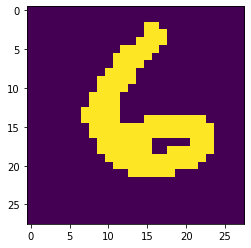

In [ ]:
k = 4587
plt.imshow(images_test[k])
print(np.argmax((model.predict(np.expand_dims(images_test[k], axis=0)))))
print(y_test[k])

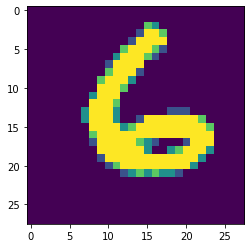

In [ ]:
temp = np.reshape(np.array(X_test.iloc[k, :]), (28, 28))
temp = temp.astype('float64')
plt.imshow(temp)

In [ ]:
img = cv2.imread('3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (100, 100), interpolation = cv2.INTER_NEAREST)
img = cv2.threshold(img, 185, 255, cv2.THRESH_BINARY_INV)[1]
print(np.argmax((model.predict(np.expand_dims(img, axis=0)))))
plt.imshow(img)

[0. 8. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 8.]
[8. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[4. 0. 0. 2. 0. 0. 0. 0. 0. 2.]
[0. 0. 0. 8. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 4. 0. 0. 0. 4. 0.]
[0. 0. 0. 0. 6. 0. 0. 0. 2. 0.]
19000344


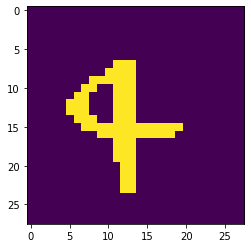

In [ ]:
img = cv2.imread('msv3.png')
# plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img.shape
width_per_num = w/8
result = '';
for k in range(8):
  start = int(width_per_num*k)
  end = int(width_per_num*(k+1))
  digit = cv2.resize(img[1:, start:end], [28, 28])
  # digit = cv2.threshold(digit, 185, 255, cv2.THRESH_BINARY_INV)[1]
  digit = cv2.adaptiveThreshold(digit,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,41,2)
  digit[0:4, :] = np.zeros([4, 28])
  digit[24:28, :] = np.zeros([4, 28])
  digit[:, 0:4] = np.zeros([28, 4])
  digit[:, 24:28] = np.zeros([28, 4])

  bbb = np.zeros(10)
  temp = np.argmax(model.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model2.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model3.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model4.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model5.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model6.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model7.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1
  temp = np.argmax(model8.predict(np.expand_dims(digit, axis=0), verbose=0))
  bbb[temp] = bbb[temp] + 1

  print(bbb)
  result += str(np.argmax(bbb))
  plt.imshow(digit)
print(result)

In [ ]:
model.save('mnist_10.h5')
model2.save('mnist_20.h5')
model3.save('mnist_50.h5')
model4.save('mnist_100.h5')
model5.save('mnist_5.h5')
model6.save('mnist_0_20000.h5')
model7.save('mnist_0_50000.h5')
model8.save('mnist_20000_end.h5')

In [ ]:
model.predict(np.expand_dims(digit, axis=0), verbose=0)*10

array([[4.8113165e-05, 6.8598893e-04, 1.2405276e-04, 7.8423764e-05,
        2.4160681e+00, 4.2860553e-04, 3.0044888e-03, 2.7755342e-02,
        7.5149202e+00, 3.6886852e-02]], dtype=float32)